## Data Collection and Feature Engineering steps

In [65]:
import numpy as np
import pandas as pd

# Download and load the train data:
train_data_url = 'https://raw.githubusercontent.com/google-research/google-research/2adf640a14f11025ae5a9d0ec493b78530d276d3/goemotions/data/train.tsv'

# Load the files into dataframes
train_data = pd.read_csv(train_data_url, sep='\t')

# comment will be the only feature
# emotion will be the target (multiple labels)
header = ["comment", "emotion", "id"]
train_data.columns = header

# Emotions dict
emotions_dict = {
    0: "admiration",
    1: "amusement",
    2: "anger",
    3: "annoyance",
    4: "approval",
    5: "caring",
    6: "confusion",
    7: "curiosity",
    8: "desire",
    9: "disappointment",
    10: "disapproval",
    11: "disgust",
    12: "embarrassment",
    13: "excitement",
    14: "fear",
    15: "gratitude",
    16: "grief",
    17: "joy",
    18: "love",
    19: "nervousness",
    20: "optimism",
    21: "pride",
    22: "realization",
    23: "relief",
    24: "remorse",
    25: "sadness",
    26: "surprise",
    27: "neutral"
}

# Remove instances with more than one emotion from each dataset
train_data = train_data[train_data['emotion'].apply(lambda x: len(x.split(',')) == 1)]

# Convert emotion column into integers
train_data['emotion'] = train_data['emotion'].apply(lambda x: ''.join(filter(str.isdigit, str(x)))).astype(int)

# Tokenize the comments using the BERT tokenizer (Convert comments into Tokens)
from transformers import BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenized_comments = tokenizer(train_data['comment'].to_list(), padding=True, truncation=True, return_tensors='pt')

# Convert tokenized data to numpy arrays
X = tokenized_comments['input_ids'].numpy()
y = train_data['emotion'].values

# Define stratified shuffle split
from sklearn.model_selection import StratifiedShuffleSplit
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and testing sets
for train_index, test_index in strat_split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

print("Training set class distribution:")
print(np.bincount(y_train))
print("Testing set class distribution:")
print(np.bincount(y_test))

Training set class distribution:
[ 2168  1322   820  1161  1498   519   686  1111   311   567  1122   398
   162   408   344  1486    31   682  1142    68   689    41   469    71
   282   654   576 10257]
Testing set class distribution:
[ 542  330  205  290  375  130  172  278   78  142  280  100   41  102
   86  371    8  171  285   17  172   10  117   17   71  163  144 2565]


# 1. Model Building - ML Classifiers

We try classic ML Classifiers first.

Here's the current research question:

**"Can we predict the sentiment of a textual comment?"**

In [66]:
import os

# Disable parallelism in huggingface/tokenizers
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid for RandomizedSearchCV
param_dist = {
    'n_estimators': [1000, 2000, 5000],
    'max_depth': [1, 30, 50, 80, 100],
    'max_features': [1, 10, 20, 30, 40],
    'min_samples_leaf': [1, 30, 50],
}

# Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(rf_classifier, param_distributions=param_dist, n_iter=3, cv=2, scoring='accuracy', verbose=4, n_jobs=-1)

# Train the classifier using RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best estimator
best_classifier = random_search.best_estimator_

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END max_depth=50, max_features=10, min_samples_leaf=50, n_estimators=2000;, score=0.353 total time=  11.4s
[CV 2/2] END max_depth=50, max_features=10, min_samples_leaf=50, n_estimators=2000;, score=0.353 total time=  11.9s
[CV 1/2] END max_depth=50, max_features=1, min_samples_leaf=50, n_estimators=5000;, score=0.353 total time=  13.1s
[CV 2/2] END max_depth=50, max_features=1, min_samples_leaf=50, n_estimators=5000;, score=0.353 total time=  17.7s
[CV 2/2] END max_depth=100, max_features=30, min_samples_leaf=1, n_estimators=2000;, score=0.376 total time= 1.4min
[CV 1/2] END max_depth=100, max_features=30, min_samples_leaf=1, n_estimators=2000;, score=0.377 total time= 1.5min


In [67]:
# Get all score evaluations
cv_results = random_search.cv_results_

# Display the results
import pandas as pd

cv_results_df = pd.DataFrame(cv_results)
# Select relevant columns to display
columns_to_display = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
cv_results_df = cv_results_df[columns_to_display]

print(cv_results_df.to_string(index=False))

                                                                             params  mean_test_score  std_test_score  rank_test_score
{'n_estimators': 2000, 'min_samples_leaf': 1, 'max_features': 30, 'max_depth': 100}         0.376519        0.000951                1
{'n_estimators': 2000, 'min_samples_leaf': 50, 'max_features': 10, 'max_depth': 50}         0.353142        0.000022                2
 {'n_estimators': 5000, 'min_samples_leaf': 50, 'max_features': 1, 'max_depth': 50}         0.353142        0.000022                2


In [68]:
best_classifier

RandomForestClassifier(max_depth=100, max_features=30, n_estimators=2000)

In [69]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from joblib import Parallel, delayed

def learning_curve(model, X, y, n_splits, train_sizes, verbose=False):
    train_scores = []
    val_scores = []

    train_scores_std = []
    val_scores_std = []

    def fit_and_score(train_index, test_index, X_subset, y_subset, model):
        X_fold, X_val_fold = X_subset[train_index], X_subset[test_index]
        y_fold, y_val_fold = y_subset[train_index], y_subset[test_index]

        model.fit(X_fold, y_fold)
        return model.score(X_fold, y_fold), model.score(X_val_fold, y_val_fold)

    for i, train_size in enumerate(train_sizes):
        X_subset = X[:int(train_size * len(X))]
        y_subset = y[:int(train_size * len(y))]
        
        cv = StratifiedKFold(n_splits=n_splits)
        
        if verbose:
            print(f"Processing train size {train_size * 100:.1f}% ({i + 1}/{len(train_sizes)})")
        
        results = Parallel(n_jobs=-1)(delayed(fit_and_score)(train_index, test_index, X_subset, y_subset, model)
                                      for train_index, test_index in cv.split(X_subset, y_subset))
        
        train_score, val_score = zip(*results)
        
        train_scores.append(np.mean(train_score))
        val_scores.append(np.mean(val_score))
        train_scores_std.append(np.std(train_score))
        val_scores_std.append(np.std(val_score))
        
        # if verbose:
        #     print(f"Train score: {train_scores[-1]:.4f} ± {train_scores_std[-1]:.4f}")
        #     print(f"Validation score: {val_scores[-1]:.4f} ± {val_scores_std[-1]:.4f}")

    train_scores = np.array(train_scores)
    val_scores = np.array(val_scores)
    train_scores_std = np.array(train_scores_std)
    val_scores_std = np.array(val_scores_std)
    
    return train_sizes, train_scores, val_scores, train_scores_std, val_scores_std



Processing train size 10.0% (1/10)
Processing train size 20.0% (2/10)
Processing train size 30.0% (3/10)
Processing train size 40.0% (4/10)
Processing train size 50.0% (5/10)
Processing train size 60.0% (6/10)
Processing train size 70.0% (7/10)
Processing train size 80.0% (8/10)
Processing train size 90.0% (9/10)
Processing train size 100.0% (10/10)


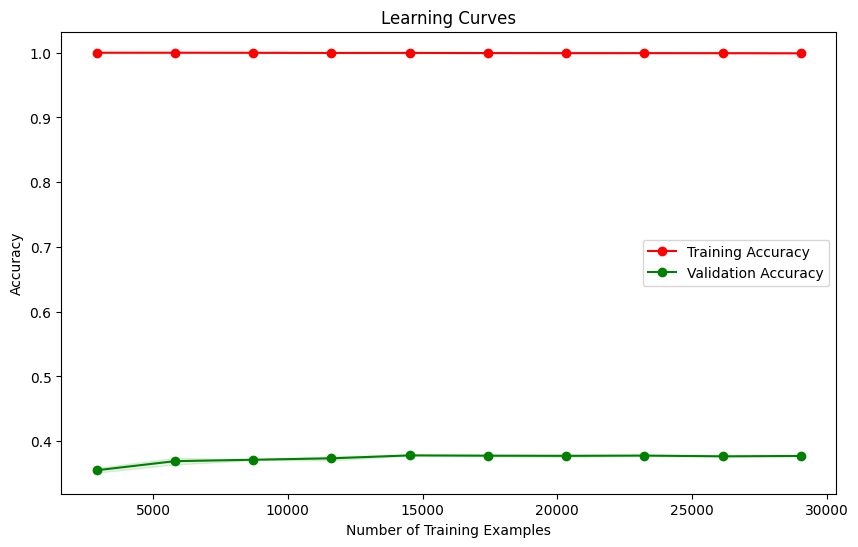

In [70]:
train_sizes, train_scores, val_scores, train_scores_std, val_scores_std = learning_curve(best_classifier,
                                                                                        X_train,
                                                                                        y_train,
                                                                                        n_splits=2,
                                                                                        train_sizes=np.linspace(0.1, 1.0, 10),  # Training set sizes from 10% to 100%
                                                                                        verbose= True
                                                                                        )


# print("Training Scores:", train_scores)
# print("Validation Scores:", val_scores)

# Plotting the learning curves with standard deviations
plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes * len(X_train), train_scores - train_scores_std,
                 train_scores + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes * len(X_train), val_scores - val_scores_std,
                 val_scores + val_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes * len(X_train), train_scores, 'o-', color="r", label='Training Accuracy')
plt.plot(train_sizes * len(X_train), val_scores, 'o-', color="g", label='Validation Accuracy')
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()
